Functions Defined.
Date-Time:  2023-10-26_15-41
Successfully opened gamma data!
Successfully opened proton data!
Shape of Tel1:  (20000,)
Shape of Tel2:  (20000,)
Shape of Tel3:  (20000,)
Shape of Tel4:  (20000,)
Shape of Labels:  (20000,)
Labels:  [1 1 1 ... 0 0 0]
/home/hanneswarnhofer/ECAP_HiWi_WorkingDirectory
[19354 17964  8960 11023 17806 11529 13438  3137 17126  1947]
Start Mapping...
... Finished Mapping
Shape of mapped_images_1:  (5000, 41, 41, 1)
Shape of mapped_images:  (4, 5000, 41, 41, 1)
New shape of mapped_images:  (5000, 4, 41, 41)
New shape of mapped_labels:  (5000, 1)
5000  events with 4 images each are available 

Shape of 'event_labels':  (5000, 1)
Shape of 'peak_times':  (5000, 4, 41, 41, 1) 

[ True  True False  True  True  True  True False False  True]
Split into Training and Test Data
Train data shape: (4023, 4, 41, 41, 1) --> 80.46 %
Test data shape: (977, 4, 41, 41, 1) --> 19.54 %
Train labels shape: (4023, 1)
Test labels shape: (977, 1)
Train data 1 shape: (4

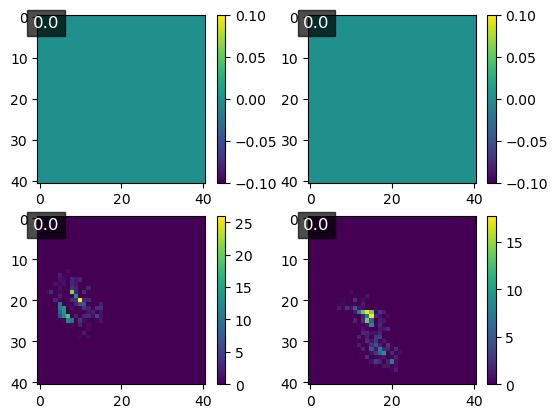

Min. and Max. Value for Image 1:  0.0  -  0.0 . Sum:  0.0
Min. and Max. Value for Image 2:  0.0  -  0.0 . Sum:  0.0
Min. and Max. Value for Image 3:  0.0  -  25.912879943847656 . Sum:  304.0083541208878
Min. and Max. Value for Image 4:  0.0  -  17.71670913696289 . Sum:  258.1585566941649
Plotting Example Event. Event Nr:  4


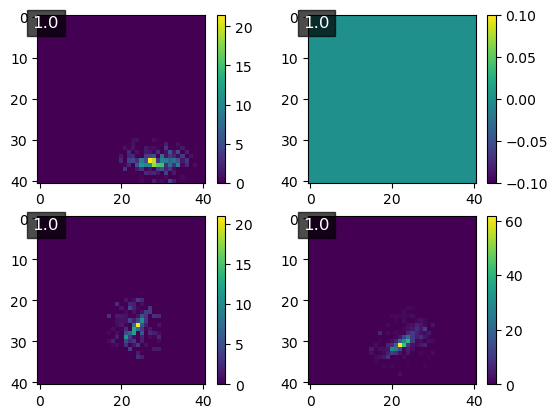

Min. and Max. Value for Image 1:  0.0  -  21.499099731445312 . Sum:  364.676172173582
Min. and Max. Value for Image 2:  0.0  -  0.0 . Sum:  0.0
Min. and Max. Value for Image 3:  0.0  -  20.944557189941406 . Sum:  250.7014093361795
Min. and Max. Value for Image 4:  0.0  -  61.57244873046875 . Sum:  624.0711559006013


In [3]:

import tables
import tables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import random

import fnmatch
import os
#import h5
import glob
import pickle
import sys
import argparse
import h5py
import os.path
import inspect
import json

from datetime import datetime
import time

from ctapipe.io import EventSource
from ctapipe import utils
from ctapipe.instrument.camera import CameraGeometry

from dl1_data_handler.reader import DL1DataReader
from dl1_data_handler.image_mapper import ImageMapper

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.layers import Input, Concatenate, concatenate, Dense,Lambda,Reshape,Embedding, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Flatten, Dropout, ConvLSTM2D, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.models import Model, Sequential

class DataManager():
    """ Data class used to manage the HDF5 data files (simulations + Auger data).
        data_path: data_path of HDF5 file, (hint: use blosc compression to ensure adequate decompression speed,
        to mitigate training bottleneck due to a slow data pipeline)
        params:
            data_path = path to HDF5 datset
        optional params:
            stats: data statistics (stats.json - needed for scaling the dataset)
            tasks: list of tasks to be included (default: ['axis', 'core', 'energy', 'xmax'])
            generator_fn: generator function used for looping over data, generator function needs to have indices and
                          shuffle args.
            ad_map_fn: "advanced mapping function" the function used to map the final dataset. Here an additional
                       preprocessing can be implemented which is mapped during training on the
                       cpu (based on tf.data.experimental.map_and_batch)
    """

    def __init__(self, data_path, stats=None, tasks=['axis', 'impact', 'energy', 'classification']):
        ''' init of DataManager class, to manage simulated (CORSIKA/Offline) and measured dataset '''
        current_timestamp = int(time.time())
        np.random.seed(current_timestamp)
        self.data_path = data_path

    def open_ipython(self):
        from IPython import embed
        embed()

    @property
    def is_data(self):
        return self.type == "Data"

    @property
    def is_mc(self):
        return self.type == "MC"

    def get_h5_file(self):
        return h5py.File(self.data_path, "r")

    def walk_tree(self, details=True):
        """ Draw the tree of yout HDF5 file to see the hierachy of your dataset
            params: detail(activate details to see shapes and used compression ops, Default: True)
        """

        def walk(file, iter_str=''):
            try:
                keys = file.keys()
            except AttributeError:
                keys = []

            for key in keys:
                try:
                    if details:
                        file[key].dtype
                        print(iter_str + str(file[key]))
                    else:
                        print(iter_str + key)
                except AttributeError:
                    print(iter_str + key)
                    walk(file[key], "   " + iter_str)

        with h5py.File(self.data_path, "r") as file:
            print("filename:", file.filename)
            for key in file.keys():
                print(' - ' + key)
                walk(file[key], iter_str='   - ')

    def extract_info(self, path):
        with self.get_h5_file() as f:
            data = f[path]
            y = np.stack(data[:].tolist())

        return {k: y[:, i] for i, k in enumerate(data.dtype.names)}, dict(data.dtype.descr)

    def make_mc_data(self):
        return self.extract_info("simulation/event/subarray/shower")

class MyGenerator(keras.utils.Sequence):

    def __init__(self,images_1,images_2,images_3,images_4,labels,batch_size):
        self.batch_size = batch_size
        self.images_1 = images_1
        self.images_2 = images_2
        self.images_3 = images_3
        self.images_4 = images_4
        self.labels = labels
        self.sample_count = len(labels[:])
        self.batch_count = int(self.sample_count/self.batch_size)
        self.current_batch = 0
        self.index = 0

    def __len__(self):
        return self.batch_count



    def __getitem__(self,index):
        idx_low  = self.current_batch*self.batch_size
        idx_high = (self.current_batch+1)*self.batch_size
        X = np.array([self.images_1[idx_low:idx_high],self.images_2[idx_low:idx_high],self.images_3[idx_low:idx_high],self.images_4[idx_low:idx_high]])
        y = np.array(self.labels[idx_low:idx_high])

        self.current_batch +=1 
        self.data = (X,y)

        return self.data
        
    ''' 

    def __getitem__(self,index):
        idx_low  = self.current_batch*self.batch_size
        idx_high = (self.current_batch+1)*self.batch_size
        images_batch_1 = self.images_1[idx_low:idx_high]
        images_batch_2 = self.images_2[idx_low:idx_high]
        images_batch_3 = self.images_3[idx_low:idx_high]
        images_batch_4 = self.images_4[idx_low:idx_high]

        labels_batch = np.array(self.labels[idx_low:idx_high])

        # Assuming your images are of shape (41, 41, 1)
        images_batch_1 = np.expand_dims(images_batch_1, axis=-1)
        images_batch_2 = np.expand_dims(images_batch_2, axis=-1)
        images_batch_3 = np.expand_dims(images_batch_3, axis=-1)
        images_batch_4 = np.expand_dims(images_batch_4, axis=-1)

        self.current_batch +=1 
        self.data = (np.array([images_batch_1, images_batch_2, images_batch_3, images_batch_4]), labels_batch)

        # MAYBE CHECK: X = np.array([...]) and y = labels_batch

        return self.data
    '''
    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= self.sample_count:
            raise StopIteration
        result = self.__getitem__(self.index) 
        self.index += 1
        return result

    def plot_batch(self, event_nr=100):
        print(np.shape(self.images_1))
        print(np.shape(self.images_1[event_nr]))
        image_batch_1 = self.images_1
        image_batch_2 = self.images_2
        image_batch_3 = self.images_3
        image_batch_4 = self.images_4
        label_batch = self.labels
        plot_image_2by2(image_batch_1,image_batch_2,image_batch_3,image_batch_4, labels=label_batch, event_nr=event_nr,string="generator")

    def __shape__(self):
        print("Shape of self.images1: ",np.shape(self.images_1))
        print("Shape of first event: ",np.shape(self.images_1[0]))

    def reset_counters(self): 
        self.current_batch = 0 

        
    def on_epoch_end(self):
        self.reset_counters()

class OnEpochBegin(keras.callbacks.Callback): # Callback class called on epoch begin to reset counters
    def on_epoch_begin(self, epoch, logs=None):
        training_generator.reset_counters()
        testing_generator.reset_counters()
        print("Epoch Begin")


def re_index_ct14(image):
    return image[5:, :, :]

def make_hess_geometry(file=None):
    # quick fix for dl1 data handler to circumvent to use ctapipe
    if file is None:
        with open(os.path.join(os.getcwd(), "geometry2d3.json")) as f: 
            attr_dict = json.load(f)

        data_ct14 = attr_dict["ct14_geo"]
        data_ct5 = attr_dict["ct5_geo"]
    else:
        data_ct14 = file["configuration/instrument/telescope/camera/geometry_0"][:].tolist()
        data_ct5 = file["configuration/instrument/telescope/camera/geometry_1"][:].tolist()

    class Geometry():
        def __init__(self, data):
            self.pix_id, self.pix_x, self.pix_y, self.pix_area = np.stack(data).T.astype(np.float32)
            self.pos_x = self.pix_x
            self.pos_y = self.pix_y

        def get_pix_pos(self):
            return np.column_stack([self.pix_x, self.pix_y]).T

    return Geometry(data_ct14), Geometry(data_ct5)

def get_current_path():
    filename = inspect.getframeinfo(inspect.currentframe()).filename
    return os.path.dirname(os.path.abspath(filename))

def rotate(pix_pos, rotation_angle=0):
    rotation_angle = rotation_angle * np.pi / 180.0
    rotation_matrix = np.matrix([[np.cos(rotation_angle), -np.sin(rotation_angle)],
                                [np.sin(rotation_angle), np.cos(rotation_angle)], ], dtype=float)

    pixel_positions = np.squeeze(np.asarray(np.dot(rotation_matrix, pix_pos)))
    return pixel_positions

def plot_image_2by2(train_data,event_nr,labels,string,dt):

    

    

    print("Plotting Example Event. Event Nr: ", event_nr)

    image1 = train_data[:,0,:,:] 
    image2 = train_data[:,1,:,:] 
    image3 = train_data[:,2,:,:] 
    image4 = train_data[:,3,:,:] 

    pltimage1 = image1[event_nr]
    pltimage2 = image2[event_nr]
    pltimage3 = image3[event_nr]
    pltimage4 = image4[event_nr]

    fig, ax = plt.subplots(2,2)

    im1 = ax[0,0].imshow(pltimage1[:,:,0], cmap='viridis',vmin=0)
    im2 = ax[0,1].imshow(pltimage2[:,:,0], cmap='viridis',vmin=0)
    im3 = ax[1,0].imshow(pltimage3[:,:,0], cmap='viridis',vmin=0)
    im4 = ax[1,1].imshow(pltimage4[:,:,0], cmap='viridis',vmin=0)

    cbar1 = fig.colorbar(im1, ax=ax[0, 0], orientation='vertical')
    cbar2 = fig.colorbar(im2, ax=ax[0, 1], orientation='vertical')
    cbar3 = fig.colorbar(im3, ax=ax[1, 0], orientation='vertical')
    cbar4 = fig.colorbar(im4, ax=ax[1, 1], orientation='vertical')


    label1 = labels[event_nr].ravel()[0]
    label2 = labels[event_nr].ravel()[1]
    label3 = labels[event_nr].ravel()[2]
    label4 = labels[event_nr].ravel()[3]

    str_label1 = '{}'.format(label1)
    str_label2 = '{}'.format(label2)
    str_label3 = '{}'.format(label3)
    str_label4 = '{}'.format(label4)

    ax[0, 0].text(0.05, 0.95, str_label1, transform=ax[0, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    ax[0, 1].text(0.05, 0.95, str_label2, transform=ax[0, 1].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    ax[1, 0].text(0.05, 0.95, str_label3, transform=ax[1, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    ax[1, 1].text(0.05, 0.95, str_label4, transform=ax[1, 1].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    plt.show()

    print("Min. and Max. Value for Image 1: ", np.min(pltimage1), " - " , np.max(pltimage1) , ". Sum: ", np.sum(pltimage1))
    print("Min. and Max. Value for Image 2: ", np.min(pltimage2), " - " , np.max(pltimage2), ". Sum: ", np.sum(pltimage2))
    print("Min. and Max. Value for Image 3: ", np.min(pltimage3), " - " , np.max(pltimage3), ". Sum: ", np.sum(pltimage3))
    print("Min. and Max. Value for Image 4: ", np.min(pltimage4), " - " , np.max(pltimage4), ". Sum: ", np.sum(pltimage4))

    #str_evnr = '{}'.format(event_nr)
    #name = "Test_images/Test_figure_evnr_" + str_evnr + "_" + string + "_" + dt + ".png"
    #fig.savefig(name)

print("Functions Defined.")

'''
parser = argparse.ArgumentParser()
parser.add_argument("-e", "--epochs", type=int)
parser.add_argument("-b", "--batch_size", type=int)
parser.add_argument("-r", "--rate", type=float)
parser.add_argument("-reg", "--regulization", type=float)
parser.add_argument("-t", "--threshold", type=float)
parser.add_argument("-c", "--cut", type=int)
parser.add_argument("-ne", "--numevents", type=int)

args = parser.parse_args()
num_epochs = args.epochs
batch_size = args.batch_size
rate = args.rate
reg = args.regulization
sum_threshold = args.threshold
cut_nonzero = args.cut
num_events = args.numevents
'''
# Define the appendix to the file, for being able to specify some general changes in the model structure and trace back the changes when comparing the results of t´different models
fnr = "FusionMethods" 

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M")
print("Date-Time: ", formatted_datetime)

num_events = 5000
amount = int(num_events * 2)
filePath_gamma="../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/ECAP_HiWi_WorkingDirectory/phase2d3_timeinfo_gamma_diffuse_hybrid_preselect_20deg_0deg.h5"
#filePath_gamma = "../../../../wecapstor1/caph/mppi111h/old_dataset/phase2d3_timeinfo_gamma_diffuse_hybrid_preselect_20deg_0deg.h5"
#filePath_gamma = "../../../../wecapstor1/caph/mppi111h/new_sims/dnn/gamma_diffuse_noZBDT_noLocDist_hybrid_v2.h5"

filePath_proton="../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/ECAP_HiWi_WorkingDirectory/phase2d3_timeinfo_proton_hybrid_preselect_20deg_0deg.h5"
#filePath_proton = "../../../../wecapstor1/caph/mppi111h/old_dataset/phase2d3_timeinfo_proton_hybrid_preselect_20deg_0deg.h5"
#filePath_proton="../../../../wecapstor1/caph/mppi111h/new_sims/dnn/proton_noZBDT_noLocDist_hybrid_v2.h5"

dm_gamma = DataManager(filePath_gamma)
f_g = dm_gamma.get_h5_file()

if num_events >= len(f_g["dl1/event/telescope/images/tel_001"][:]) : num_events = len(f_g["dl1/event/telescope/images/tel_001"][:]) - 2
if amount >= len(f_g["dl1/event/telescope/images/tel_001"][:]) : amount = len(f_g["dl1/event/telescope/images/tel_001"][:]) - 1

tel1g_raw = f_g["dl1/event/telescope/images/tel_001"][0:amount]
tel2g_raw = f_g["dl1/event/telescope/images/tel_002"][0:amount]
tel3g_raw = f_g["dl1/event/telescope/images/tel_003"][0:amount]
tel4g_raw = f_g["dl1/event/telescope/images/tel_004"][0:amount]
#tel5g_raw = f_g["dl1/event/telescope/images/tel_005"][0:amount]

print("Successfully opened gamma data!")

labelsg = np.stack([data[2] for data in tel1g_raw])
labelsg_ones = np.ones_like(labelsg)

f_g.close()

dm_proton = DataManager(filePath_proton)
f_p = dm_proton.get_h5_file()

tel1p_raw = f_p["dl1/event/telescope/images/tel_001"][0:amount]
tel2p_raw = f_p["dl1/event/telescope/images/tel_002"][0:amount]
tel3p_raw = f_p["dl1/event/telescope/images/tel_003"][0:amount]
tel4p_raw = f_p["dl1/event/telescope/images/tel_004"][0:amount]
#tel5p_raw = f_p["dl1/event/telescope/images/tel_005"][0:amount]

print("Successfully opened proton data!")

labelsp = np.stack([data[2] for data in tel1p_raw])
labelsp_zeros = np.zeros_like(labelsp)

tel1 = np.concatenate((tel1g_raw,tel1p_raw),axis=0)
tel2 = np.concatenate((tel2g_raw,tel2p_raw),axis=0)
tel3 = np.concatenate((tel3g_raw,tel3p_raw),axis=0)
tel4 = np.concatenate((tel4g_raw,tel4p_raw),axis=0)
#tel5 = np.concatenate((tel5g_raw,tel5p_raw),axis=0)
labels = np.concatenate((labelsg_ones,labelsp_zeros),axis=0)

del tel1g_raw
del tel2g_raw
del tel3g_raw
del tel4g_raw

del tel1p_raw
del tel2p_raw
del tel3p_raw
del tel4p_raw

f_p.close()

del labelsp
del labelsg
del labelsp_zeros
del labelsg_ones

print("Shape of Tel1: ",np.shape(tel1))
print("Shape of Tel2: ",np.shape(tel2))
print("Shape of Tel3: ",np.shape(tel3))
print("Shape of Tel4: ",np.shape(tel4))
#print("Shape of Tel5: ",np.shape(tel5))
print("Shape of Labels: ",np.shape(labels))
print("Labels: ",labels)

geo_ct14, geo_ct5 = make_hess_geometry()
print(os.getcwd())
ct_14_mapper = ImageMapper(camera_types=["HESS-I"], pixel_positions={"HESS-I": rotate(geo_ct14.get_pix_pos())}, mapping_method={"HESS-I": "axial_addressing"})
#ct_5_mapper = ImageMapper(camera_types=["HESS-II"], pixel_positions={"HESS-II": rotate(geo_ct5.get_pix_pos())}, mapping_method={"HESS-II": "axial_addressing"})

mapped_images_1 = np.empty((num_events, 41,41,1))
mapped_images_2 = np.empty((num_events, 41,41,1))
mapped_images_3 = np.empty((num_events, 41,41,1))
mapped_images_4 = np.empty((num_events, 41,41,1))
#mapped_images_4 = np.empty((num_events, 41,41,1))
mapped_labels = np.empty(num_events)

length = num_events
max_value = len(tel1)
random_list = np.random.randint(max_value, size=length)
image_nr = 0

print(random_list[0:10])

cut_nonzero = 2
threshold_value = 0.0001  # Adjust this threshold value as needed

print("Start Mapping...")
for event_nr in random_list:


    
    image_1 = ct_14_mapper.map_image(tel1[event_nr][3][:, np.newaxis], 'HESS-I')
    image_2 = ct_14_mapper.map_image(tel2[event_nr][3][:, np.newaxis], 'HESS-I')
    image_3 = ct_14_mapper.map_image(tel3[event_nr][3][:, np.newaxis], 'HESS-I')   
    image_4 = ct_14_mapper.map_image(tel4[event_nr][3][:, np.newaxis], 'HESS-I')
    #image_5 = ct_5_mapper.map_image(tel5[event_nr][3][:, np.newaxis], 'HESS-II')   

    # Apply threshold on the sum of pixel values
    #sum_threshold = 60  # Adjust this value to your desired threshold
    sum_threshold = 60 #args.threshold

    if np.sum(image_1) < sum_threshold:
        image_1[:] = 0
    if np.sum(image_2) < sum_threshold:
        image_2[:] = 0
    if np.sum(image_3) < sum_threshold:
        image_3[:] = 0
    if np.sum(image_4) < sum_threshold:
        image_4[:] = 0
     
    # Set all pixels lower than the threshold value to zero
    image_1[image_1 < threshold_value] = 0
    image_2[image_2 < threshold_value] = 0
    image_3[image_3 < threshold_value] = 0
    image_4[image_4 < threshold_value] = 0
    #image_5[image_5 < threshold_value] = 0

    non_zero_count = sum(1 for img in [image_1, image_2, image_3, image_4] if np.sum(img) > 0)
    if non_zero_count >= cut_nonzero:
        mapped_images_1[image_nr] = image_1
        mapped_images_2[image_nr] = image_2
        mapped_images_3[image_nr] = image_3
        mapped_images_4[image_nr] = image_4
        #mapped_images_5[image_nr] = image_5
        mapped_labels[image_nr] = labels[event_nr]
        image_nr += 1
    
print("... Finished Mapping")

'''
print("Start Mapping...")
for event_nr in random_list:
    mapped_images_1[image_nr] = ct_14_mapper.map_image(tel1[event_nr][3][:, np.newaxis], 'HESS-I')
    mapped_images_2[image_nr] = ct_14_mapper.map_image(tel2[event_nr][3][:, np.newaxis], 'HESS-I')
    mapped_images_3[image_nr] = ct_14_mapper.map_image(tel3[event_nr][3][:, np.newaxis], 'HESS-I')   
    mapped_images_4[image_nr] = ct_14_mapper.map_image(tel4[event_nr][3][:, np.newaxis], 'HESS-I')
    mapped_labels[image_nr] = labels[event_nr]
    image_nr=image_nr+1
print("... Finished Mapping")
'''
#########################################   MAYBE TRY CONVERTING ALL "EMPTY" IMAGES IN SUCH A WAY
#########################################   THAT ALL PIXELS BECOME ZERO? IF SUM < 0 -> ALL_PIXELS=0
#########################################   


mapped_images = np.array([mapped_images_1,mapped_images_2,mapped_images_3,mapped_images_4]) #mapped_images_5])
print("Shape of mapped_images_1: ",np.shape(mapped_images_1))
print("Shape of mapped_images: ",np.shape(mapped_images))



del tel1
del tel2
del tel3
del tel4
del labels

del mapped_images_1
del mapped_images_2
del mapped_images_3
del mapped_images_4

# Reshape the final array, so it is present in the same way as MoDAII data
mapped_images = np.transpose(mapped_images, (1, 0, 2, 3, 4))
mapped_images = np.squeeze(mapped_images, axis=-1)
mapped_labels = mapped_labels[:,np.newaxis]

print("New shape of mapped_images: ",np.shape(mapped_images))
print("New shape of mapped_labels: ",np.shape(mapped_labels))


########################################################
# START WITH CNN STUFF


patience = 5
input_shape = (41, 41, 1)
#input_shape5 = (72,72,1)
pool_size = 2
kernel_size = 2

# some reshaping for the further use of the timing data in the CNN
mapped_images = mapped_images.reshape((*np.shape(mapped_images),1))

# overview about the important data array for later usage
print(np.shape(mapped_images)[0], " events with 4 images each are available \n")
print("Shape of 'event_labels': ",np.shape(mapped_labels))
print("Shape of 'peak_times': ",np.shape(mapped_images),"\n")

# split into random training data (80%) and test data (20%)
train_data = []
test_data = []
train_labels = []
test_labels = [] 

#data_dummy = mapped_images

random_selection = np.random.rand(np.shape(mapped_images)[0]) <= 0.8


train_data.append(mapped_images[random_selection])
test_data.append(mapped_images[~random_selection])
train_labels.append(mapped_labels[random_selection])
test_labels.append(mapped_labels[~random_selection])

#mapped_images = data_dummy
#del data_dummy

print(random_selection[0:10])

# free some memory space
del mapped_images
del mapped_labels

# convert to numpy array and reshape 
train_data = np.array(train_data)
train_data = train_data.reshape(np.shape(train_data[0]))
test_data = np.array(test_data)
test_data = test_data.reshape(np.shape(test_data[0]))

train_labels = np.array(train_labels)
train_labels = train_labels.reshape(np.shape(train_labels[0]))
test_labels = np.array(test_labels)
test_labels = test_labels.reshape(np.shape(test_labels[0]))

train_labels_multishape = np.zeros_like(train_data)
test_labels_multishape = np.zeros_like(test_data)

len_train = np.shape(train_data)[0]
len_test = np.shape(test_data)[0]

for i in range(0,len_train):
    train_labels_multishape[i,:,:,:] = train_labels[i]

for k in range(0,len_test):
    test_labels_multishape[k,:,:,:] = test_labels[k]

# overvew about the splitting into training and test data
print("Split into Training and Test Data")
print("Train data shape:", np.shape(train_data) , "-->",round(100*len_train/(len_train+len_test),2),"%")
print("Test data shape:", np.shape(test_data), "-->",round(100*len_test/(len_train+len_test),2), "%")
print("Train labels shape:", np.shape(train_labels))
print("Test labels shape:", np.shape(test_labels))

# split up different "telescopes" for the usage in the seperate single view CNNs (probably in the most long-winded way possible, but lets just ignore that)
train_data_1 = train_data[:,0,:,:] 
train_data_2 = train_data[:,1,:,:] 
train_data_3 = train_data[:,2,:,:] 
train_data_4 = train_data[:,3,:,:] 
#train_data_5 = train_data[:,4,:,:] 

test_data_1 = test_data[:,0,:,:]
test_data_2 = test_data[:,1,:,:]
test_data_3 = test_data[:,2,:,:]
test_data_4 = test_data[:,3,:,:]
#test_data_5 = test_data[:,4,:,:]

train_labels_1 = train_labels_multishape[:,0,:,:]
train_labels_2 = train_labels_multishape[:,1,:,:]
train_labels_3 = train_labels_multishape[:,2,:,:]
train_labels_4 = train_labels_multishape[:,3,:,:]
#train_labels_5 = train_labels_multishape[:,4,:,:]

test_labels_1 = test_labels_multishape[:,0,:,:]
test_labels_2 = test_labels_multishape[:,1,:,:]
test_labels_3 = test_labels_multishape[:,2,:,:]
test_labels_4 = test_labels_multishape[:,3,:,:]
#test_labels_5 = test_labels_multishape[:,4,:,:]

print("Train data 1 shape:", np.shape(train_data_1))
print("Train labels 1 shape:", np.shape(train_labels_1))

print("Test data 1 shape:", np.shape(test_data_1))
print("Test labels 1 shape:", np.shape(test_labels_1))



print("Test data 1:",test_data_1)


mean_values = np.mean(train_data,axis=(2,3))
max_values = np.amax(train_data,axis=(2,3))

mean = np.mean(mean_values)
max = np.max(max_values)

plot_image_2by2(train_data,4,train_labels_multishape,string="train",dt=formatted_datetime)
#plot_image_2by2(train_data,40,train_labels_multishape,string="train",dt=formatted_datetime)
#plot_image_2by2(train_data,400,train_labels_multishape,string="train",dt=formatted_datetime)
#plot_image_2by2(train_data,4000,train_labels_multishape,string="train",dt=formatted_datetime)

plot_image_2by2(test_data,4,test_labels_multishape,string="test",dt=formatted_datetime)
#plot_image_2by2(test_data,40,test_labels_multishape,string="test",dt=formatted_datetime)
#plot_image_2by2(test_data,400,test_labels_multishape,string="test",dt=formatted_datetime)
#plot_image_2by2(test_data,4000,test_labels_multishape,string="test",dt=formatted_datetime)

In [24]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LeakyReLU, Dropout, concatenate, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Define the model for the single-view CNNs with classification output
def create_single_view_cnn_model(input_shape, num_classes, freeze=False):
    input_layer = Input(shape=input_shape)
    x = Conv2D(filters=200, kernel_size=(3, 3), padding='same')(input_layer)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(filters=100, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(filters=50, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(filters=50, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(filters=100, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(filters=100, kernel_size=(3, 3), padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(filters=100, kernel_size=(3, 3), padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    
    # Classification output layer
    output = Dense(num_classes, activation='sigmoid')(Flatten()(x))  # For binary classification

    model = Model(inputs=input_layer, outputs=output)

    if freeze:
        for layer in model.layers:
            layer.trainable = False

    return model

# Define the model for the combination of the previous CNNs and the final CNN for multi-view classification
def create_multiview_model(single_view_models, fusion_type):
    input_shapes = [model.input_shape[1:] for model in single_view_models]
    single_view_inputs = [Input(shape=input_shape) for input_shape in input_shapes]

    # Define the fusion technique (fully connected late fusion or max fusion)
    if fusion_type == 'fully_connected':
        fusion = concatenate([model(input) for model, input in zip(single_view_models, single_view_inputs)])
        x = Dropout(0.2)(fusion)
        x = Conv2D(filters=100, kernel_size=(2, 2), activation='relu', padding='same', input_shape=input_shape)(x)
        x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    elif fusion_type == 'max_fusion':
        # Implement max fusion
        # ...
        print("max_fusion")
    else: 
        raise ValueError("Invalid fusion_type. Use 'fully_connected' or 'max_fusion'.")

    # Additional layers for multi-view classification
    # ...

    output = Dense(1, activation='sigmoid')(Flatten()(x))  # Binary classification output

    model = Model(inputs=single_view_inputs, outputs=output)
    return model

# Function to train the first part of the model with single-view images
def train_single_view_models(single_view_models, train_data, train_labels, num_epochs, batch_size):
    for i, model in enumerate(single_view_models):
        print(f"Training Single-View Model {i + 1}")
        model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])
        model.fit(train_data[:, i, :, :, :], train_labels, epochs=num_epochs, batch_size=batch_size)

# Function to run the multi-view model with selected fusion technique
def run_multiview_classification(single_view_models, test_data, fusion_type):
    fusion_model = create_multiview_model(single_view_models, fusion_type)
    fusion_model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])
    return fusion_model.predict([test_data[:, i, :, :, :] for i in range(4)])

# Example usage:
input_shape = (41, 41, 1)
num_classes = 1  # For binary classification
num_epochs = 10
batch_size = 32

# Create single-view CNN models
single_view_models = [create_single_view_cnn_model(input_shape, num_classes, freeze=False) for _ in range(4)]

# Train the single-view models
train_single_view_models(single_view_models, train_data, train_labels, num_epochs, batch_size)

# Freeze the single-view models
for model in single_view_models:
    model.trainable = False

# Select the fusion technique
fusion_type = 'fully_connected'  # Choose 'fully_connected' or 'max_fusion'

# Run multi-view classification
predictions = run_multiview_classification(single_view_models, test_data, fusion_type)


Training Single-View Model 1
Epoch 1/10
126/126 [==============================] - 80s 626ms/step - loss: 0.7143 - accuracy: 0.4134
Epoch 2/10
126/126 [==============================] - 68s 537ms/step - loss: 0.6947 - accuracy: 0.4094
Epoch 3/10
126/126 [==============================] - 51s 404ms/step - loss: 0.6770 - accuracy: 0.4477
Epoch 4/10
126/126 [==============================] - 52s 409ms/step - loss: 0.6990 - accuracy: 0.4599
Epoch 5/10
126/126 [==============================] - 52s 416ms/step - loss: 0.6848 - accuracy: 0.4549
Epoch 6/10
126/126 [==============================] - 54s 427ms/step - loss: 0.6455 - accuracy: 0.5063
Epoch 7/10
126/126 [==============================] - 54s 430ms/step - loss: 0.6761 - accuracy: 0.5145
Epoch 8/10
126/126 [==============================] - 53s 419ms/step - loss: 0.6834 - accuracy: 0.4862
Epoch 9/10
126/126 [==============================] - 52s 416ms/step - loss: 0.6383 - accuracy: 0.5213
Epoch 10/10
126/126 [=======================

ValueError: Input 0 of layer "conv2d_176" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 4)

In [29]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LeakyReLU, Dropout, concatenate, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

rate=0.2
reg = 0.001

# Define the common CNN architecture for both single-view and multi-view models
def create_shared_cnn_model(input_shape, num_classes, with_output=False):
    #input_layer = Input(shape=input_shape)

    '''
    x = Conv2D(filters=25, kernel_size=(3, 3), padding='same')(input_layer)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(filters=30, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(filters=50, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(filters=50, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(filters=100, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(filters=100, kernel_size=(3, 3), padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    '''

    model = Sequential()

    model.add(Conv2D(filters=25, kernel_size=kernel_size, activation='relu', padding='same',kernel_regularizer=regularizers.l2(reg), input_shape=input_shape,))
    model.add(MaxPooling2D(pool_size=pool_size, padding='same'))

    model.add(Dropout(rate))
    model.add(Conv2D(filters=50, kernel_size=kernel_size, activation='relu', padding='same', kernel_regularizer=regularizers.l2(reg)))
    model.add(MaxPooling2D(pool_size=pool_size, padding='same'))

    model.add(Dropout(rate))
    model.add(Conv2D(filters=50, kernel_size=kernel_size, activation='relu', padding='same',kernel_regularizer=regularizers.l2(reg)))
    model.add(MaxPooling2D(pool_size=pool_size, padding='same'))

    model.add(Dropout(rate))
    model.add(Conv2D(filters=100, kernel_size=kernel_size, activation='relu', padding='same',kernel_regularizer=regularizers.l2(reg)))
    model.add(MaxPooling2D(pool_size=pool_size, padding='same'))

    if with_output:
        model.add(Flatten())
        model.add(Dropout(rate))
        model.add(Dense(100,activation='relu'))
        model.add(Dropout(rate))
        model.add(Dense(50,activation='relu'))
        model.add(Dropout(rate))
        model.add(Dense(num_classes,activation='sigmoid'))

    return model

# Define the model for the combination of the previous CNNs and the final CNN for multi-view classification
def create_multiview_model(single_view_models, fusion_type):
    input_shapes = [model.input_shape[1:] for model in single_view_models]
    single_view_inputs = [Input(shape=input_shape) for input_shape in input_shapes]

    # Define the fusion technique (fully connected late fusion or max fusion)
    if fusion_type == 'fully_connected':
        fusions = [model(input) for model, input in zip(single_view_models, single_view_inputs)]
        fusion = concatenate(fusions)
        x = Dropout(0.2)(fusion)
        x = Conv2D(filters=100, kernel_size=(2, 2), activation='relu', padding='same')(x)
        x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
        x = Dropout(0.2)(x)
        x = Flatten()(x)
    elif fusion_type == 'max_fusion':
        x = MaxPooling2D(pool_size=(2, 2), padding='same')(concatenate([model(input) for model, input in zip(single_view_models, single_view_inputs)]))
        x = Flatten()(x)
    else:
        raise ValueError("Invalid fusion_type. Use 'fully_connected' or 'max_fusion'.")

    output = Dense(1, activation='sigmoid')(x)  # Binary classification output

    model = Model(inputs=single_view_inputs, outputs=output)
    return model

# Function to train the first part of the model with single-view images
def train_single_view_models(single_view_models, train_data, train_labels, num_epochs, batch_size):
    for i, model in enumerate(single_view_models):
        print(f"Training Single-View Model {i + 1}")
        model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])
        model.fit(train_data[:, i, :, :, :], train_labels, epochs=num_epochs, batch_size=batch_size)

# Function to run the multi-view model with selected fusion technique
def run_multiview_classification(single_view_models, test_data, fusion_type):
    fusion_model = create_multiview_model(single_view_models, fusion_type)
    fusion_model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])
    return fusion_model.predict([test_data[:, i, :, :, :] for i in range(4)])

# Example usage:
input_shape = (41, 41, 1)
num_classes = 1  # For binary classification
num_epochs = 5
batch_size = 32

# Create single-view CNN models
single_view_models = [create_shared_cnn_model(input_shape, num_classes, with_output=True) for _ in range(4)]

# Train the single-view models
train_single_view_models(single_view_models, train_data, train_labels, num_epochs, batch_size)

# Freeze the single-view models
for model in single_view_models:
    model.trainable = False

# Select the fusion technique
fusion_type = 'fully_connected'  # Choose 'fully_connected' or 'max_fusion'

# Run multi-view
predictions_fully_connected = run_multiview_classification(single_view_models, test_data, fusion_type)


Training Single-View Model 1
Epoch 1/5
 33/126 [======>.......................] - ETA: 18s - loss: 2.1491 - accuracy: 0.4034

In [4]:
mean_values = np.mean(train_data,axis=(2,3))
max_values = np.amax(train_data,axis=(2,3))

mean = np.mean(mean_values)
max = np.max(max_values)

print("Overall Mean:", mean)
print("Overall Max:", max)

Overall Mean: 0.4282942977918682
Overall Max: 11800.990234375


In [21]:
from tensorflow.keras.layers import Lambda, Reshape, Layer

rate = 0.1
reg = 0.00001


#Define the model for the single-view CNNs
def create_cnn_model(input_shape,freeze=False):
    input_layer = Input(shape=input_shape)

    Conv1 = Conv2D(filters=200, kernel_size=kernel_size, padding='same',kernel_regularizer=regularizers.l2(reg), input_shape=input_shape,)(input_layer)
    LeakyRelu1 = LeakyReLU(alpha=0.1)(Conv1)
    MaxPool1 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu1)

    #print("Before first Dropout")

    Dropout1 = Dropout(rate)(MaxPool1)
    Conv2 = Conv2D(filters=100, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout1)
    LeakyRelu2 = LeakyReLU(alpha=0.1)(Conv2) 
    MaxPool2 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu2)

    Dropout2 = Dropout(rate)(MaxPool2)
    Conv3 = Conv2D(filters=50, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout2)
    LeakyRelu3 = LeakyReLU(alpha=0.1)(Conv3) 
    MaxPool3 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu3)

    Dropout3 = Dropout(rate)(MaxPool3)
    Conv4 = Conv2D(filters=50, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout3)
    LeakyRelu4 = LeakyReLU(alpha=0.1)(Conv4) 
    MaxPool4 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu4)

    Dropout4 = Dropout(rate)(MaxPool4)
    Conv5 = Conv2D(filters=100, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout4)
    LeakyRelu5 = LeakyReLU(alpha=0.1)(Conv5) 
    MaxPool5 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu5)

    Dropout5 = Dropout(rate)(MaxPool5)
    Conv6 = Conv2D(filters=100, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout5)
    MaxPool6 = MaxPooling2D(pool_size=pool_size, padding='same')(Conv6)

    Dropout6 = Dropout(rate)(MaxPool6)
    Conv7 = Conv2D(filters=100, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout6)
    MaxPool7 = MaxPooling2D(pool_size=pool_size, padding='same')(Conv7)

    model = Model(inputs=input_layer, outputs=MaxPool7)

    if freeze:
        for layer in model.layers:
            layer.trainable = False

    return model

# Define the model for the combination of the previous CNNs and the final CNN for classification

def run_multiview_model_latefusionfc(models, input_shapes, freeze=False):
    model_inputs = [Input(shape=input_shape) for input_shape in input_shapes]
    single_view_models = [create_cnn_model(input_shape, freeze) for input_shape in input_shapes]

    merged = concatenate([model(input) for model, input in zip(single_view_models, model_inputs)])


    Dropout1 = Dropout(rate)(merged)
    Conv_merged1 = Conv2D(filters=100,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout1)
    MaxPool_merged1 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged1)

    Dropout2 = Dropout(rate)(MaxPool_merged1)
    Conv_merged2 = Conv2D(filters=50,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout2)
    MaxPool_merged2 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged2)

    Dropout3 = Dropout(rate)(MaxPool_merged2)
    Conv_merged3 = Conv2D(filters=80,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout3)
    MaxPool_merged3 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged3)

    Dropout31 = Dropout(rate)(MaxPool_merged3)
    Conv_merged31 = Conv2D(filters=140,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout31)
    MaxPool_merged31 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged31)

    Flat_merged1 = Flatten()(MaxPool_merged31)
    Dropout4 = Dropout(rate)(Flat_merged1)
    dense_layer_merged1 = Dense(units=100, activation='relu')(Dropout4)

    Dropout6 = Dropout(rate)(dense_layer_merged1)
    dense_layer_merged3 = Dense(units=1, activation='sigmoid')(Dropout6)

    model = Model(inputs=input_shapes, outputs=dense_layer_merged3)
    return model


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


# Define hyperparameter search space
param_dist = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'rate': [0.25, 0.5, 0.75],
    'filters': [16, 32, 64],
    'kernel_size': [(3, 3), (4, 4), (5, 5)]
}

# Wrap the Keras model for use with scikit-learn
cnn_model = KerasClassifier(build_fn=create_cnn_model, epochs=num_epochs, batch_size=batch_size, verbose=0)

# Perform random search with cross-validation
random_search = RandomizedSearchCV(cnn_model, param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1)
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

In [18]:
from tensorflow.keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
num_epochs = 5
batch_size = 64

# Create the loss function with from_logits=True
loss_fn = BinaryCrossentropy(from_logits=True)
early_stopping_callback_1=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,verbose=1,mode='min')

single_view_models = []
for i in range(4):
    cnn_model = create_cnn_model(input_shape, freeze=False)  # Create a new CNN model
    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    cnn_model.fit(train_data[:, i, :, :], train_labels, epochs=num_epochs, batch_size=batch_size, validation_data=(test_data[:, i, :, :], test_labels), callbacks=[early_stopping_callback_1])

    # Append the trained model to the list
    single_view_models.append(cnn_model)

Epoch 1/5
63/63 [==============================] - 62s 972ms/step - loss: 1.8538 - accuracy: 0.0021 - val_loss: 0.9329 - val_accuracy: 0.0000e+00
Epoch 2/5
63/63 [==============================] - 54s 858ms/step - loss: 0.8161 - accuracy: 9.2615e-04 - val_loss: 0.7514 - val_accuracy: 0.0000e+00
Epoch 3/5
63/63 [==============================] - 54s 867ms/step - loss: 0.7835 - accuracy: 0.0016 - val_loss: 0.7651 - val_accuracy: 0.0000e+00
Epoch 4/5
63/63 [==============================] - 48s 769ms/step - loss: 0.7776 - accuracy: 0.0070 - val_loss: 0.7380 - val_accuracy: 0.0000e+00
Epoch 5/5
63/63 [==============================] - 45s 708ms/step - loss: 0.7818 - accuracy: 0.0032 - val_loss: 0.7389 - val_accuracy: 0.0000e+00
Epoch 1/5
63/63 [==============================] - 57s 890ms/step - loss: 1.8027 - accuracy: 0.0071 - val_loss: 0.8330 - val_accuracy: 0.0000e+00
Epoch 2/5
63/63 [==============================] - 45s 712ms/step - loss: 0.8290 - accuracy: 9.8063e-04 - val_loss: 0.74

In [22]:
# Step 2: Freeze the layers of the first CNN models
for model in single_view_models:
    for layer in model.layers:
        layer.trainable = False
# Step 3: Create the multi-view model using the frozen first CNN models and late fusion layers
input_shapes = [input_shape] * 4
model_multi = run_multiview_model_latefusionfc(single_view_models, input_shapes, freeze=True)

# Step 4: Train the multi-view model for multi-view classification
model_multi.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_multi.fit([test_data[:, i, :, :] for i in range(4)], test_labels, epochs=num_epochs, batch_size=batch_size, validation_data=([test_data[:, i, :, :] for i in range(4)], test_labels), callbacks=[early_stopping_callback_1])

ValueError: Found unexpected instance while processing input tensors for keras functional model. Expecting KerasTensor which is from tf.keras.Input() or output from keras layer call(). Got: 41

In [23]:
from tensorflow.keras.layers import Lambda, Reshape, Layer

rate = 0.0001
reg = 0.00005

#Define the model for the single-view CNNs
def create_cnn_model(input_shape,freeze=False):
    input_layer = Input(shape=input_shape)

    Conv1 = Conv2D(filters=200, kernel_size=kernel_size, padding='same',kernel_regularizer=regularizers.l2(reg), input_shape=input_shape,)(input_layer)
    LeakyRelu1 = LeakyReLU(alpha=0.1)(Conv1)
    MaxPool1 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu1)

    #print("Before first Dropout")

    Dropout1 = Dropout(rate)(MaxPool1)
    Conv2 = Conv2D(filters=100, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout1)
    LeakyRelu2 = LeakyReLU(alpha=0.1)(Conv2) 
    MaxPool2 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu2)

    Dropout2 = Dropout(rate)(MaxPool2)
    Conv3 = Conv2D(filters=50, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout2)
    LeakyRelu3 = LeakyReLU(alpha=0.1)(Conv3) 
    MaxPool3 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu3)

    Dropout3 = Dropout(rate)(MaxPool3)
    Conv4 = Conv2D(filters=50, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout3)
    LeakyRelu4 = LeakyReLU(alpha=0.1)(Conv4) 
    MaxPool4 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu4)

    Dropout4 = Dropout(rate)(MaxPool4)
    Conv5 = Conv2D(filters=100, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout4)
    LeakyRelu5 = LeakyReLU(alpha=0.1)(Conv5) 
    MaxPool5 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu5)

    Dropout5 = Dropout(rate)(MaxPool5)
    Conv6 = Conv2D(filters=100, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout5)
    MaxPool6 = MaxPooling2D(pool_size=pool_size, padding='same')(Conv6)

    Dropout6 = Dropout(rate)(MaxPool6)
    Conv7 = Conv2D(filters=100, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout6)
    MaxPool7 = MaxPooling2D(pool_size=pool_size, padding='same')(Conv7)

    model = Model(inputs=input_layer, outputs=MaxPool7)

    if freeze:
    for layer in model.layers:
        layer.trainable = False

    return model

# Define the model for the combination of the previous CNNs and the final CNN for classification

def run_multiview_model(models,inputs):

    merged = concatenate(models)

    Dropout1 = Dropout(rate)(merged)
    Conv_merged1 = Conv2D(filters=100,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout1)
    MaxPool_merged1 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged1)

    Dropout2 = Dropout(rate)(MaxPool_merged1)
    Conv_merged2 = Conv2D(filters=50,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout2)
    MaxPool_merged2 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged2)

    Dropout3 = Dropout(rate)(MaxPool_merged2)
    Conv_merged3 = Conv2D(filters=80,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout3)
    MaxPool_merged3 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged3)

    Dropout31 = Dropout(rate)(MaxPool_merged3)
    Conv_merged31 = Conv2D(filters=140,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout31)
    MaxPool_merged31 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged31)

    Flat_merged1 = Flatten()(MaxPool_merged31)
    Dropout4 = Dropout(rate)(Flat_merged1)
    dense_layer_merged1 = Dense(units=100, activation='relu')(Dropout4)

    Dropout6 = Dropout(rate)(dense_layer_merged1)
    dense_layer_merged3 = Dense(units=1, activation='sigmoid')(Dropout6)

    model = Model(inputs=inputs, outputs=dense_layer_merged3)
    return model

class CustomFusionLayer(Layer):
    def __init__(self, **kwargs):
        super(CustomFusionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Define your custom variables here
        self.conv_weights = self.add_weight("conv_weights", shape=(1, 1, 4, 1), trainable=True)

    def call(self, inputs):
        # Implement your custom operation here
        fused_feature_map = tf.nn.conv2d(inputs, self.conv_weights, strides=[1, 1, 1, 1], padding="SAME")
        return tf.nn.relu(fused_feature_map)

def run_multiview_model_latefusionmax(models,inputs):

    #max_pooled = CustomFusionLayer()(models)  #Lambda(lambda x: tf.reduce_max(x, axis=0), output_shape=input_shape)(models)
    max_pooled = Lambda(lambda x: tf.reduce_max(x, axis=0), output_shape=input_shape)(models)
    Dropout1 = Dropout(rate)(max_pooled)
    Conv_merged1 = Conv2D(filters=100,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout1)
    MaxPool_merged1 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged1)

    Dropout2 = Dropout(rate)(MaxPool_merged1)
    Conv_merged2 = Conv2D(filters=50,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout2)
    MaxPool_merged2 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged2)

    Dropout3 = Dropout(rate)(MaxPool_merged2)
    Conv_merged3 = Conv2D(filters=80,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout3)
    MaxPool_merged3 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged3)

    Dropout31 = Dropout(rate)(MaxPool_merged3)
    Conv_merged31 = Conv2D(filters=140,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout31)
    MaxPool_merged31 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged31)

    Flat_merged1 = Flatten()(MaxPool_merged31)
    Dropout4 = Dropout(rate)(Flat_merged1)
    dense_layer_merged1 = Dense(units=100, activation='relu')(Dropout4)

    Dropout6 = Dropout(rate)(dense_layer_merged1)
    dense_layer_merged3 = Dense(units=1, activation='sigmoid')(Dropout6)

    model = Model(inputs=inputs, outputs=dense_layer_merged3)
    return model

def run_multiview_model_earlymax(models,inputs):
    stacked = tf.stack(models, axis=4)
    fused_feature_map = tf.reduce_max(stacked,axis=4)
    Dropout1 = Dropout(rate)(fused_feature_map)
    Conv_merged1 = Conv2D(filters=100,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout1)
    MaxPool_merged1 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged1)

    '''

    Dropout2 = Dropout(rate)(MaxPool_merged1)
    Conv_merged2 = Conv2D(filters=50,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout2)
    MaxPool_merged2 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged2)

    Dropout3 = Dropout(rate)(MaxPool_merged2)
    Conv_merged3 = Conv2D(filters=80,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout3)
    MaxPool_merged3 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged3)

    Dropout31 = Dropout(rate)(MaxPool_merged3)
    Conv_merged31 = Conv2D(filters=140,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout31)
    MaxPool_merged31 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged31)

    Flat_merged1 = Flatten()(MaxPool_merged31)
    Dropout4 = Dropout(rate)(Flat_merged1)
    dense_layer_merged1 = Dense(units=100, activation='relu')(Dropout4)
    '''

    Dropout6 = Dropout(rate)(MaxPool_merged1) #(dense_layer_merged1)
    dense_layer_merged3 = Dense(units=1, activation='sigmoid')(Dropout6)

    model = Model(inputs=inputs, outputs=dense_layer_merged3)
    return model


def run_multiview_model_earlyconv(models,inputs):
    stacked = tf.stack(models, axis=4)
    # Define a 1x1 convolutional layer with trainable weights
    conv_weights = tf.Variable(tf.random.normal([1, 1, 4, 1]), trainable=True)
    convolution = tf.nn.conv2d(stacked, conv_weights, strides=[1, 1, 1, 1], padding="SAME")
    layer_output = convolution # Replace this with the specific layer you want to inspect
    print("Shape of layer output convolution:", tf.shape(layer_output))

    # Apply ReLU activation or any other desired activation function
    fused_feature_map = tf.nn.relu(convolution)
    layer_output = fused_feature_map # Replace this with the specific layer you want to inspect
    print("Shape of layer output fused_feature_map:", tf.shape(layer_output))
    #reshaped_tensor = Reshape((1,1,100))(fused_feature_map)
    Dropout1 = Dropout(rate)(fused_feature_map) #(reshaped_tensor)
    layer_output = Dropout1  # Replace this with the specific layer you want to inspect
    print("Shape of layer output Dropout1:", tf.shape(layer_output))
    Conv_merged1 = Conv2D(filters=100,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout1)
    layer_output = Conv_merged1  # Replace this with the specific layer you want to inspect
    print("Shape of layer output Conv_merged1:", tf.shape(layer_output))
    reshaped_tensor2 = tf.reshape(Conv_merged1,(-1,1,1,100))
    MaxPool_merged1 = MaxPooling2D(pool_size=2,padding='same')(reshaped_tensor2) #(Conv_merged1)
    layer_output = MaxPool_merged1  # Replace this with the specific layer you want to inspect
    print("Shape of layer output MaxPoolmerged1:", tf.shape(layer_output))

    Dropout2 = Dropout(rate)(MaxPool_merged1)
    Conv_merged2 = Conv2D(filters=50,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout2)
    MaxPool_merged2 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged2)

    Dropout3 = Dropout(rate)(MaxPool_merged2)
    Conv_merged3 = Conv2D(filters=80,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout3)
    MaxPool_merged3 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged3)

    Dropout31 = Dropout(rate)(MaxPool_merged3)
    Conv_merged31 = Conv2D(filters=140,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout31)
    MaxPool_merged31 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged31)

    Flat_merged1 = Flatten()(MaxPool_merged31)
    Dropout4 = Dropout(rate)(Flat_merged1)
    dense_layer_merged1 = Dense(units=100, activation='relu')(Dropout4)

    Dropout6 = Dropout(rate)(dense_layer_merged1)
    dense_layer_merged3 = Dense(units=1, activation='sigmoid')(Dropout6)

    model = Model(inputs=inputs, outputs=dense_layer_merged3)
    return model

# Create four separate CNN models
input_1 = Input(shape=input_shape)
cnn_model_1 = create_cnn_model(input_shape)(input_1)

input_2 = Input(shape=input_shape)
cnn_model_2 = create_cnn_model(input_shape)(input_2)

input_3 = Input(shape=input_shape)
cnn_model_3 = create_cnn_model(input_shape)(input_3)

input_4 = Input(shape=input_shape)
cnn_model_4 = create_cnn_model(input_shape)(input_4)

model_multi_fc = run_multiview_model([cnn_model_1, cnn_model_2, cnn_model_3, cnn_model_4],[input_1, input_2, input_3, input_4])
model_multi_fc.summary()
#model_multi_max = run_multiview_model_latefusionmax([cnn_model_1, cnn_model_2, cnn_model_3, cnn_model_4],[input_1, input_2, input_3, input_4])
#model_multi_max.summary()
#model_multi_earlymax = run_multiview_model_earlymax([cnn_model_1, cnn_model_2, cnn_model_3, cnn_model_4],[input_1, input_2, input_3, input_4])
#model_multi_earlymax.summary()
#model_multi_earlyconv = run_multiview_model_earlyconv([cnn_model_1, cnn_model_2, cnn_model_3, cnn_model_4],[input_1, input_2, input_3, input_4])
#model_multi_earlyconv.summary()

Model: "model_88"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_107 (InputLayer)         [(None, 41, 41, 1)]  0           []                               
                                                                                                  
 input_109 (InputLayer)         [(None, 41, 41, 1)]  0           []                               
                                                                                                  
 input_111 (InputLayer)         [(None, 41, 41, 1)]  0           []                               
                                                                                                  
 input_113 (InputLayer)         [(None, 41, 41, 1)]  0           []                               
                                                                                           

In [24]:
from keras.losses import BinaryCrossentropy
num_epochs = 10
batch_size = 32

# Create the loss function with from_logits=True
loss_fn = BinaryCrossentropy(from_logits=True)

# Compile the model using the created loss function
model_multi_earlyconv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping_callback_1=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,verbose=1,mode='min')
historymax = model_multi_earlyconv.fit([train_data[:,i,:,:]/max for i in range(4)],train_labels,epochs=num_epochs,batch_size=batch_size,validation_data=([test_data[:,i,:,:] for i in range(4)], test_labels), callbacks=[early_stopping_callback_1])


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'Equal' defined at (most recent call last):
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_141848/1319341933.py", line 11, in <module>
      historymax = model_multi_earlyconv.fit([train_data[:,i,:,:]/max for i in range(4)],train_labels,epochs=num_epochs,batch_size=batch_size,validation_data=([test_data[:,i,:,:] for i in range(4)], test_labels), callbacks=[early_stopping_callback_1])
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/keras/engine/training.py", line 998, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/keras/engine/training.py", line 1092, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/keras/metrics/base_metric.py", line 143, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/keras/metrics/base_metric.py", line 700, in update_state
      matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/keras/metrics/metrics.py", line 3605, in binary_accuracy
      metrics_utils.binary_matches(y_true, y_pred, threshold), axis=-1
    File "/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 933, in binary_matches
      return tf.cast(tf.equal(y_true, y_pred), backend.floatx())
Node: 'Equal'
Incompatible shapes: [3200,1] vs. [32,1]
	 [[{{node Equal}}]] [Op:__inference_train_function_48375]